In [1]:
%load_ext autoreload
%autoreload 2

# Applying CRIPS-DM Methodology to a Business Problem

## Dataset 1 - Predicting Customer Churn in the Telecomunication Provider

## 3. Modeling

### 3.2. Support Vector Machine

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
X_train = pd.read_csv('../data/processed/X_train.csv')
y_train = pd.read_csv('../data/processed/y_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')
y_test = pd.read_csv('../data/processed/y_test.csv')

In [4]:
y_train = y_train.values.ravel()
y_val = y_val.values.ravel()
y_test = y_test.values.ravel()

In [13]:
from sklearn.svm import SVC

In [14]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report, ConfusionMatrixDisplay
from joblib import dump

In [18]:
svm = SVC(random_state=8, probability=True)
svm.fit(X_train, y_train)

SVC(probability=True, random_state=8)

In [19]:
dump(svm, '../models/svm_reg_1.joblib')

['../models/svm_reg_1.joblib']

In [20]:
def support_vector_machine(model):
    y_train_preds = model.predict(X_train)
    y_val_preds = model.predict(X_val)
    
    y_train_probs = model.predict_proba(X_train)[:, 1]
    y_val_probs = model.predict_proba(X_val)[:, 1]
    
    train_accuracy = accuracy_score(y_train, y_train_preds)
    train_precision = precision_score(y_train, y_train_preds)
    train_recall = recall_score(y_train, y_train_preds)
    train_f1 = f1_score(y_train, y_train_preds)
    train_roc_auc = roc_auc_score(y_train, y_train_probs)
    
    val_accuracy = accuracy_score(y_val, y_val_preds)
    val_precision = precision_score(y_val, y_val_preds)
    val_recall = recall_score(y_val, y_val_preds)
    val_f1 = f1_score(y_val, y_val_preds)
    val_roc_auc = roc_auc_score(y_val, y_val_probs)
    
    train_score = pd.DataFrame({
        'accuracy': train_accuracy,
        'precision': train_precision,
        'recall': train_recall,
        'f1-score': train_f1,
        'roc-auc': train_roc_auc}, index=['Training Set'])
    
    val_score = pd.DataFrame({
        'accuracy': val_accuracy,
        'precision': val_precision,
        'recall': val_recall,
        'f1-score': val_f1,
        'roc-auc': val_roc_auc}, index=['Validation Set'])

    score = pd.concat([train_score, val_score])
    print(score)
    
    
    ConfusionMatrixDisplay.from_estimator(model, X_train, y_train, normalize='true')
    ConfusionMatrixDisplay.from_estimator(model, X_val, y_val, normalize='true')                                     
    
    plt.figure()
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    plt.plot(fpr_train, tpr_train, label='Train ROC-curve')
    plt.plot(fpr_val, tpr_val, label='Validate ROC-curve')

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-Curve')
    plt.legend()
    
    plt.show()
    
    svm_val = pd.DataFrame({'accuracy': val_accuracy,
                             'precision': val_precision,
                             'recall': val_recall,
                             'f1-score': val_f1,
                             'roc-auc': val_roc_auc}, index=['Support Vector Machine'])
    
    return(svm_val)

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.948033   0.987890  0.907186  0.945819  0.992114
Validation Set  0.882353   0.648148  0.364583  0.466667  0.759596


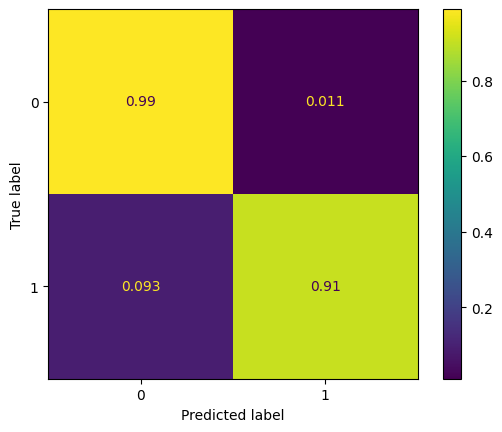

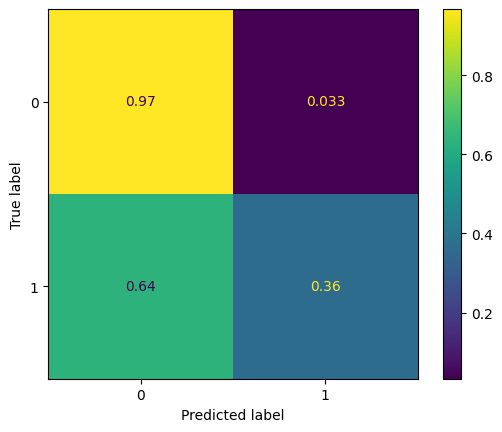

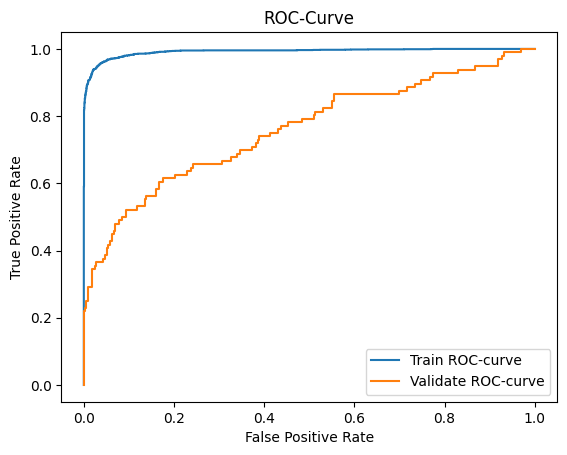

,accuracy,precision,recall,f1-score,roc-auc
Support Vector Machine,0.882353,0.648148,0.364583,0.466667,0.759596


In [21]:
support_vector_machine(svm)

The model perform really well on the training set, however it doesn't perform as effective to the validation set. There were a drop in all performance metrics suggesting that there might be an overfitting to the training data. We'll try to do the hyperparameter tuning to see if we can address this issues.

### Reduce Overfitting with Kernel Selection

default = rbf

In [24]:
kernel = ['linear', 'poly', 'rbf', 'sigmoid']

In [25]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in kernel:
    svc = SVC(random_state=8, probability=True, kernel=i).fit(X_train, y_train)
    y_train_preds = svc.predict(X_train)
    y_val_preds = svc.predict(X_val)
    
    y_train_probs = svc.predict_proba(X_train)[:, 1]
    y_val_probs = svc.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_kernel = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=kernel)

tune_kernel

/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
linear,0.853507,0.858824,1.000000,0.000000,0.707015,0.000000,0.828364,0.000000,0.930902,0.703143
poly,0.940975,0.817647,0.943632,0.370370,0.937981,0.416667,0.940798,0.392157,0.983402,0.705711
rbf,0.948033,0.882353,0.987890,0.648148,0.907186,0.364583,0.945819,0.466667,0.992114,0.759596
sigmoid,0.551326,0.523529,0.551903,0.109589,0.545766,0.333333,0.548817,0.164948,0.597218,0.450432


In [26]:
def plot_performance(parameter, xlabel):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(16, 5))
    
    ax1.plot(parameter, train_accuracy, label='train accuracy')
    ax1.plot(parameter, val_accuracy, label='val accuracy')
    ax1.legend()
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel('accuracy')
    ax1.set_title('Accuracy Score')
    
    ax2.plot(parameter, train_precision, label='train precision')
    ax2.plot(parameter, val_precision, label='val precision')
    ax2.legend()
    ax2.set_xlabel(xlabel)
    ax2.set_ylabel('precision')
    ax2.set_title('Precision Score')
    
    ax3.plot(parameter, train_recall, label='train recall')
    ax3.plot(parameter, val_accuracy, label='val recall')
    ax3.legend()
    ax3.set_xlabel(xlabel)
    ax3.set_ylabel('recall')
    ax3.set_title('Recall Score')
    
    ax4.plot(parameter, train_f1, label='train f1')
    ax4.plot(parameter, val_f1, label='val f1')
    ax4.legend()
    ax4.set_xlabel(xlabel)
    ax4.set_ylabel('f1')
    ax4.set_title('F1-Score')
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_probs)
    fpr_val, tpr_val, _ = roc_curve(y_val, y_val_probs)
    
    ax5.plot(fpr_train, tpr_train, label='train roc-auc')
    ax5.plot(fpr_val, tpr_val, label='val roc-auc')
    ax5.legend()
    ax5.set_xlabel('false positive rate')
    ax5.set_ylabel('true positive rate')
    ax5.set_title('ROC-AUC Score')
    
    plt.subplots_adjust(wspace=0.4)
    plt.show()    

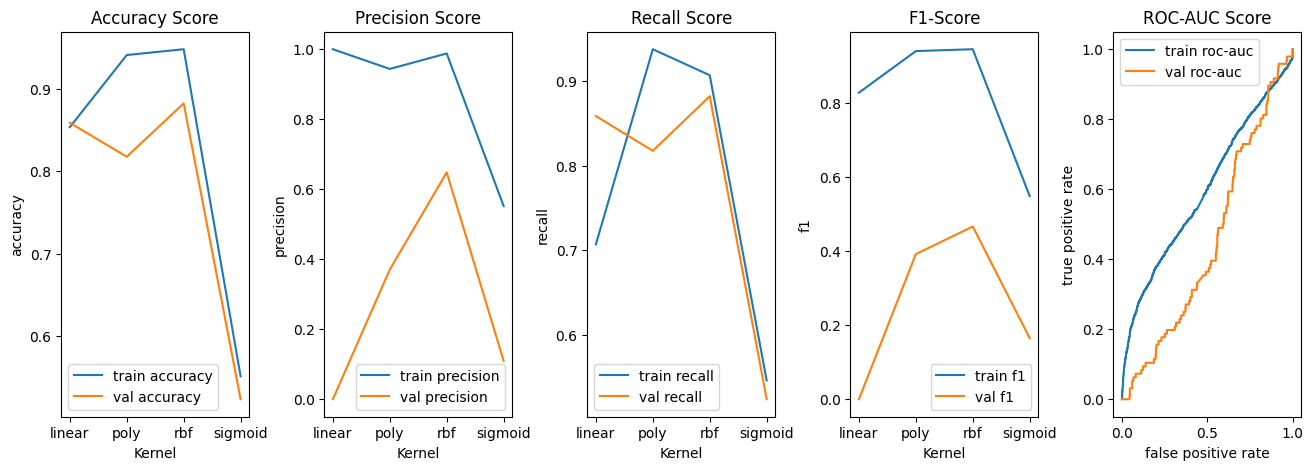

In [27]:
plot_performance(kernel, 'Kernel')

### Reduce Overfitting with Regularization(C)

default = 1

In [28]:
c = [0.1, 0.5, 1, 10, 100]

In [29]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in c:
    svc = SVC(random_state=8, probability=True, kernel='rbf', C=i).fit(X_train, y_train)
    y_train_preds = svc.predict(X_train)
    y_val_preds = svc.predict(X_val)
    
    y_train_probs = svc.predict_proba(X_train)[:, 1]
    y_val_probs = svc.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_c = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=c)

tune_c

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
0.1,0.858426,0.869118,0.951509,0.555556,0.755346,0.364583,0.842155,0.440252,0.947635,0.742883
0.5,0.935201,0.880882,0.984293,0.641509,0.884517,0.354167,0.931741,0.456376,0.986669,0.760461
1.0,0.948033,0.882353,0.987890,0.648148,0.907186,0.364583,0.945819,0.466667,0.992114,0.759596
10.0,0.992301,0.864706,0.997837,0.528571,0.986741,0.385417,0.992258,0.445783,0.999680,0.730825
100.0,1.000000,0.845588,1.000000,0.449438,1.000000,0.416667,1.000000,0.432432,1.000000,0.711562


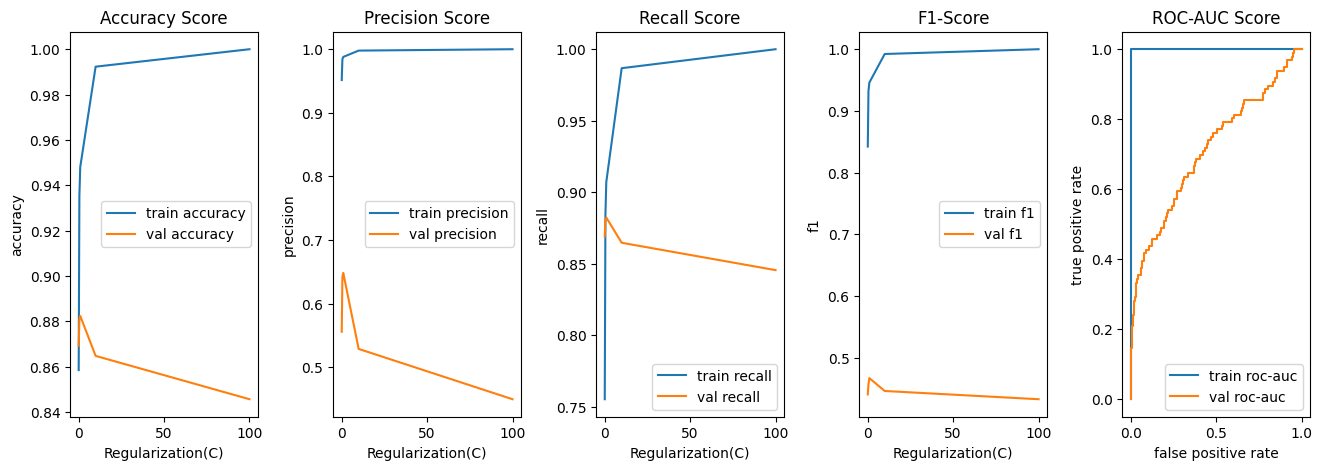

In [30]:
plot_performance(c, 'Regularization(C)')

### Reduce Overfitting with gamma

default = scale

In [31]:
gamma = ['scale', 'auto']

In [33]:
train_accuracy = []
train_precision = []
train_recall = []
train_f1 = []
train_roc_auc = []

val_accuracy = []
val_precision = []
val_recall = []
val_f1 = []
val_roc_auc = []
    
for i in gamma:
    svc = SVC(random_state=8, probability=True, kernel='rbf', C=1, gamma=i).fit(X_train, y_train)
    y_train_preds = svc.predict(X_train)
    y_val_preds = svc.predict(X_val)
    
    y_train_probs = svc.predict_proba(X_train)[:, 1]
    y_val_probs = svc.predict_proba(X_val)[:, 1]
        
    train_accuracy.append(accuracy_score(y_train, y_train_preds))
    train_precision.append(precision_score(y_train, y_train_preds))
    train_recall.append(recall_score(y_train, y_train_preds))
    train_f1.append(f1_score(y_train, y_train_preds))
    train_roc_auc.append(roc_auc_score(y_train, y_train_probs))
    
    val_accuracy.append(accuracy_score(y_val, y_val_preds))
    val_precision.append(precision_score(y_val, y_val_preds))
    val_recall.append(recall_score(y_val, y_val_preds))
    val_f1.append(f1_score(y_val, y_val_preds))
    val_roc_auc.append(roc_auc_score(y_val, y_val_probs))
    
tune_gamma = pd.DataFrame({'train_accuracy': train_accuracy,
                       'val_accuracy': val_accuracy,
                       'train_precision': train_precision,
                       'val_precision': val_precision,
                       'train_recall': train_recall,
                       'val_recall': val_recall,
                       'train_f1': train_f1,
                       'val_f1': val_f1,
                       'train_roc_auc': train_roc_auc,
                       'val_roc_auc': val_roc_auc}, index=gamma)

tune_gamma

,train_accuracy,val_accuracy,train_precision,val_precision,train_recall,val_recall,train_f1,val_f1,train_roc_auc,val_roc_auc
scale,0.948033,0.882353,0.987890,0.648148,0.907186,0.364583,0.945819,0.466667,0.992114,0.759596
auto,0.923011,0.886765,0.987673,0.711111,0.856715,0.333333,0.917545,0.453901,0.979857,0.760220


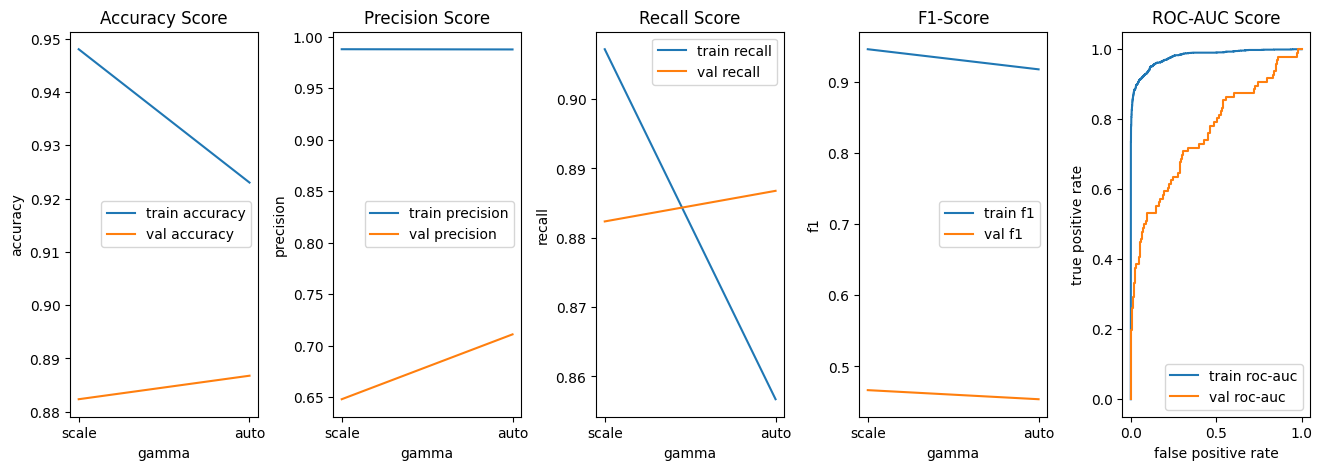

In [34]:
plot_performance(gamma, 'gamma')

### Randomized Search

In [43]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer

In [40]:
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'f1-score': make_scorer(f1_score),
    'roc_auc': make_scorer(roc_auc_score)
}

In [41]:
param = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'C': [0.1, 0.5, 1, 10, 100],
    'gamma': ['scale', 'auto']}

In [42]:
svm = SVC(kernel='rbf')

In [50]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=8)

In [51]:
svm_random = RandomizedSearchCV(estimator=svm,
                               param_distributions=param,
                               n_iter=50,
                               cv=cv,
                               n_jobs=1,
                               random_state=8,
                               verbose=1,
                               refit='roc_auc')

In [52]:
svm_random.fit(X_train, y_train)

/Users/narongvatchingpayakmon/Projects/internship_c/internship_c_dataset_1/.venv/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 40 is smaller than n_iter=50. Running 40 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 40 candidates, totalling 400 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=8, shuffle=True),
                   estimator=SVC(), n_iter=50, n_jobs=1,
                   param_distributions={'C': [0.1, 0.5, 1, 10, 100],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'poly', 'rbf',
                                                   'sigmoid']},
                   random_state=8, refit='roc_auc', verbose=1)

In [53]:
print('Best hyperparameters:', svm_random.best_params_)
print("Best evaluation scores:", svm_random.best_score_)

Best hyperparameters: {'kernel': 'rbf', 'gamma': 'scale', 'C': 10}
Best evaluation scores: 0.9437581214883142


### Model After Hyperparameter Tuning

In [58]:
svc_tune = SVC(random_state=8, probability=True, kernel='rbf', C=10, gamma='scale')
svc_tune.fit(X_train, y_train)

SVC(C=10, probability=True, random_state=8)

In [56]:
dump(svc_tune, '../models/svm_reg_tune.joblib')

['../models/svm_reg_tune.joblib']

                accuracy  precision    recall  f1-score   roc-auc
Training Set    0.992301   0.997837  0.986741  0.992258  0.999680
Validation Set  0.864706   0.528571  0.385417  0.445783  0.730825


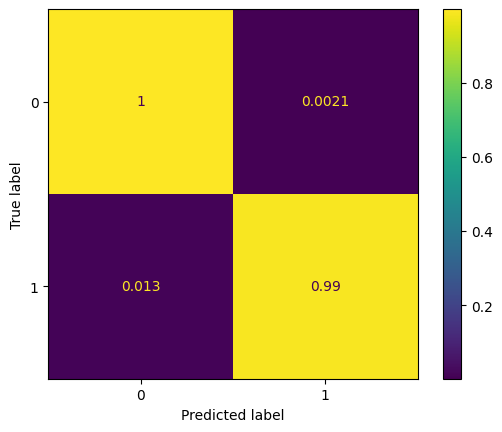

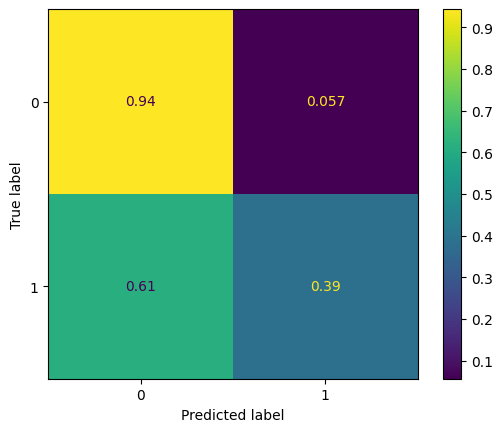

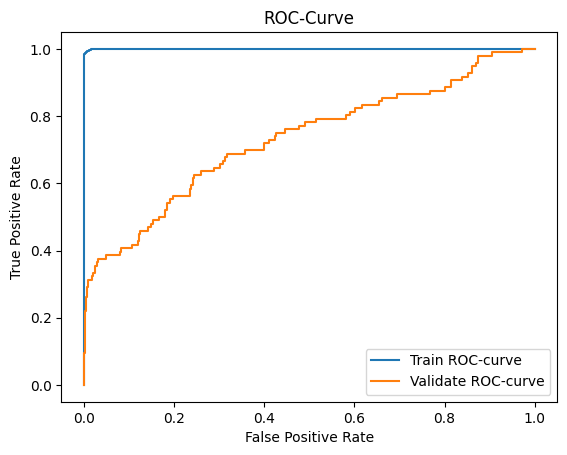

In [59]:
svm = support_vector_machine(svc_tune)

**True Positive**: Correctly predicted "churn"

**True Negative**: Correctly predicted "not churn"

**False Positive**: Predicted "churn", but actually "not churn"

**False Negative**: Predicted "not churn", but actually "churn"



- The low True Positive (31%) in the validation set mean that the model is missing out on correctly identifying customers who are at risk of churning and could lead to miss opportunity for retention.

- The high False Negative (69%) in the validation set suggest that the model might not be able to capture the actual churn customers and predicted as not churn.

In [129]:
logistic.to_csv('../data/processed/model/1_logistic.csv', index=False)